In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import leastsq,curve_fit

In [2]:
#analysis_master_path='Y:/Rb/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\

exp_id='2018_02_07_00_08_36_Open loop Ramsey with Ryd 780A, parked r1-r2, reduced FORT depth, fixed t_gap'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)

C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
print q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
retention = q.apply_thresholds()
print q.get_retention()['retention']

[u'zz_outermost_iteration']

[[[ 0.68211921  0.44367816  0.42192691  0.79775281  0.86813187]
  [ 0.68831169  0.42857143  0.47        0.77310924  0.74242424]
  [ 0.66548043  0.46028037  0.44666667  0.78431373  0.68918919]
  [ 0.72121212  0.68598131  0.67333333  0.79166667  0.70731707]
  [ 0.65814696  0.43220339  0.39333333  0.82608696  0.78461538]
  [ 0.68458781  0.41706161  0.40199336  0.80412371  0.73195876]
  [ 0.68181818  0.46310433  0.40199336  0.75206612  0.825     ]
  [ 0.65986395  0.46428571  0.43        0.83636364  0.8490566 ]
  [ 0.63257576  0.45412844  0.42857143  0.7875      0.81690141]
  [ 0.6900369   0.45333333  0.44186047  0.80246914  0.84057971]
  [ 0.64620939  0.49547511  0.44518272  0.8556701   0.73846154]
  [ 0.63385827  0.42548077  0.45        0.77922078  0.83333333]
  [ 0.63197026  0.4665127   0.37        0.83018868  0.83636364]
  [ 0.68881119  0.50721154  0.38666667  0.85263158  0.68      ]
  [ 0.6894198   0.45823928  0.3986711   0.77647059  0.74074074]
  [ 0.65098

    Save & load from numpy

In [104]:
exp_id='2018_02_07_00_08_36_Open loop Ramsey with Ryd 780A, parked r1-r2, reduced FORT depth, fixed t_gap'
# I'm saving retention to npy array.
for key in ['retention','ivar','error']:
    np.save(exp_id+key,q.get_retention()[key])


Plotting retentions

<IPython.core.display.Javascript object>


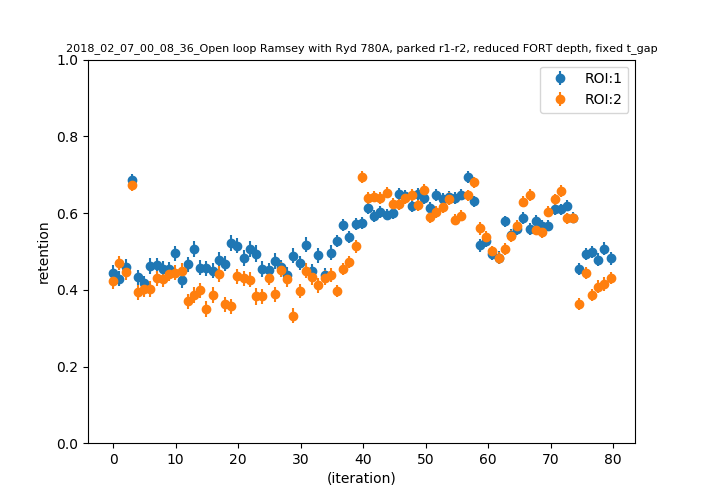

In [14]:
# Assumes you have hdf5 and QDP class on it.
fig, ax = plt.subplots()
e=0 # experiment 0
for roi in [1,2]:
    data = retention['ivar'][e][:,roi]
    reten = retention['retention'][e][:,roi]
    err = retention['error'][e][:,roi]
    ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o')
plt.title(exp_id,fontsize=8)
plt.show()
ax.set_ylim(0, 1)
ax.set_xlabel(xlab+"(iteration)")
ax.set_ylabel('retention')
ax.legend()

In [ ]:
Estimation of freq change

In [92]:
def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset): # decaying sinusoidal
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def sin_fit(datax,datay):
    [fit,p] = curve_fit(sin,datax,datay,[0.4,1,-0.19,1])
    return fit

In [93]:
# Using fitted values from expid=2018_02_06_23_42_45_Open loop Ramsey with Ryd 780A, parked r1-r2, reduced FORT depth
fitted_parameters=[]
fitted_parameters.append([  6.37872411e-03, 4.09044975e-01,   4.44270007e+02,   7.01776901e-01,   4.15199634e-01])
fitted_parameters.append([  3.04638495e-03, 5.12751790e-01 ,  4.53938577e+02,   5.51812904e-01,  4.45195028e-01])

tgap=0.002

def freq_diff(roi,y):
    if roi==1:
        result=est_freq(y,tgap,fitted_parameters[0][0],
                        fitted_parameters[0][1],
                        fitted_parameters[0][2],
                        fitted_parameters[0][3],
                        fitted_parameters[0][4]
                       )
    elif roi==2:
        result=est_freq(y,tgap,fitted_parameters[1][0],
                        fitted_parameters[1][1],
                        fitted_parameters[1][2],
                        fitted_parameters[1][3],
                       fitted_parameters[1][4]
                       )
    return result

<IPython.core.display.Javascript object>


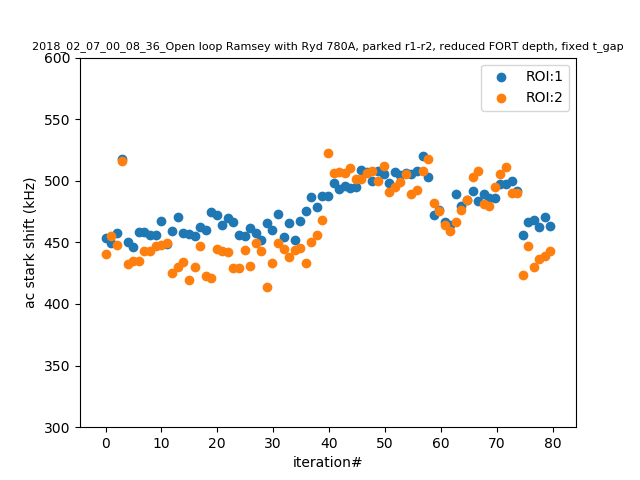

In [102]:
fig, ax = plt.subplots()

e=0 # experiment 0
for roi in [1,2]:
    ydata=fitted_parameters[roi-1][2]+freq_diff(roi, retention['retention'][e][:,roi])
    data = retention['ivar'][e][:,roi]
    ax.scatter(data,ydata,label="ROI:{}".format(roi))
plt.title(exp_id,fontsize=8)
plt.show()
ax.set_ylim(300, 600)
ax.set_xlabel(xlab+"iteration#")
ax.set_ylabel('ac stark shift (kHz)')
ax.legend()

Pull raw beam position data (bypassing AAS)

In [107]:
print q['variables'].iteritems()

AttributeError: QDP instance has no attribute '__getitem__'

In [123]:
def get_iterobj(QDP,experiment,iteration,key):
    return QDP.experiments[experiment]['iterations'][iteration][key]

e=0
FORT_camera_dataX=[]
FORT_camera_dataY=[]
Red_camera_dataX=[]
Red_camera_dataY=[]
for key in ['FORT_camera_dataX','FORT_camera_dataY','Red_camera_dataX','Red_camera_dataY']:
    for i in range(0,len(data)):
        value=get_iterobj(q,e,i,key)
        if key=='FORT_camera_dataX':
            FORT_camera_dataX.append(value)
        elif key=='FORT_camera_dataY':
            FORT_camera_dataY.append(value)
        elif key=='Red_camera_dataX':
            Red_camera_dataX.append(value)
        elif key=='Red_camera_dataY':
            Red_camera_dataY.append(value)
        

<IPython.core.display.Javascript object>


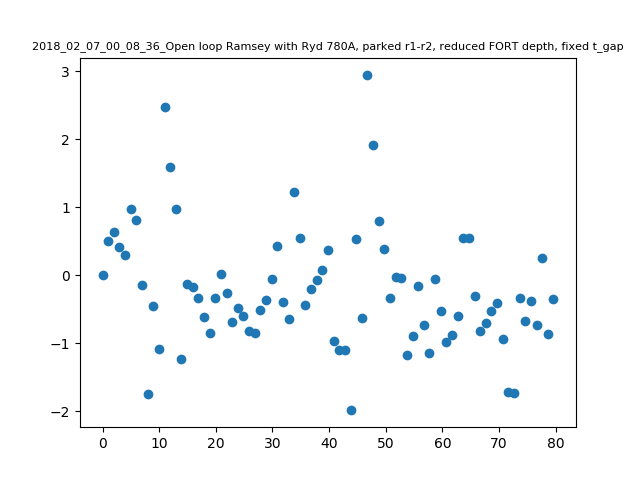

<IPython.core.display.Javascript object>


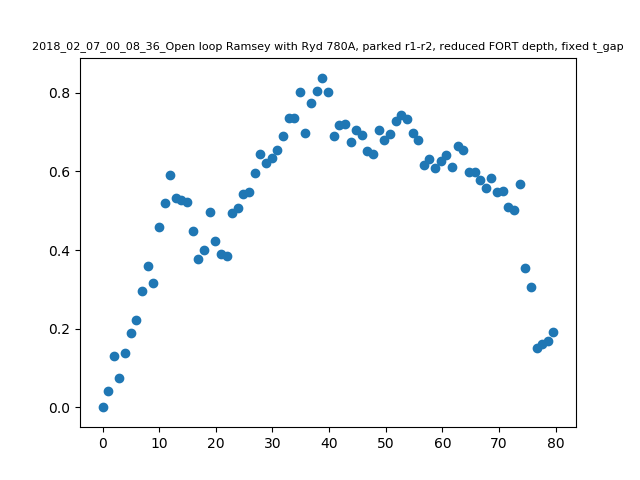

In [142]:
fig, ax = plt.subplots()
ydata=np.array(Red_camera_dataX)+np.array(FORT_camera_dataX) # 
xdata=range(0,len(data))
ax.scatter(data,ydata-ydata[0],label="ROI:{}".format(roi))
plt.title(exp_id,fontsize=8)
plt.show()
#ax.set_ylim(300, 600)
#ax.set_xlabel(xlab+"iteration#")
#ax.set_ylabel('ac stark shift (kHz)')
#ax.legend()

fig, ax = plt.subplots()
ydata=np.array(Red_camera_dataY)-np.array(FORT_camera_dataY)
xdata=range(0,len(data))
ax.scatter(data,ydata-ydata[0],label="ROI:{}".format(roi))
plt.title(exp_id,fontsize=8)
plt.show()


<IPython.core.display.Javascript object>


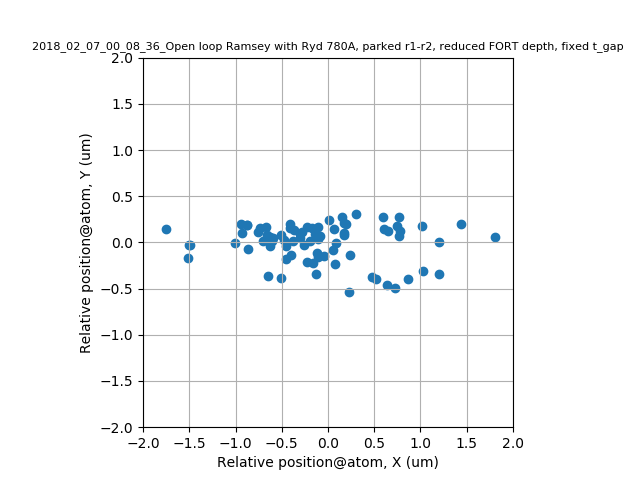

In [140]:
fig, ax = plt.subplots()
Ydata=np.array(Red_camera_dataY)-np.array(FORT_camera_dataY)
Xdata=np.array(Red_camera_dataX)+np.array(FORT_camera_dataX)
ax.scatter(Xdata-np.nanmean(Xdata),Ydata-np.nanmean(Ydata))
plt.title(exp_id,fontsize=8)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel("Relative position@atom, X (um)")
ax.set_ylabel("Relative position@atom, Y (um)")
ax.legend()
ax.set_aspect('equal')
ax.grid(True)
plt.show()

In [141]:
q.experiments[0]['iterations'][0]

{'FORT_camera_dataX': 624.3553062538316,
 'FORT_camera_dataY': 746.27065408824535,
 'Red_camera_dataX': 450.82255131275781,
 'Red_camera_dataY': 542.05629190706634,
 'loaded': array([ 302.,  435.,  301.,   89.,   91.]),
 'loading': array([ 0.46749226,  0.67337461,  0.46594427,  0.1377709 ,  0.14086687]),
 'quantized_data': array([[[ 1.,  1.,  1.,  1.,  1.],
         [ 0.,  1.,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.]],
 
        [[ 0.,  1.,  1.,  0.,  0.],
         [ 0.,  1.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.]],
 
        [[ 1.,  1.,  1.,  0.,  0.],
         [ 1.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.]],
 
        ..., 
        [[ 1.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.]],
 
        [[ 1.,  0.,  0.,  0.,  0.],
         [ 1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.]],
 
        [[ 0.,  1.,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.]]